MainProcess


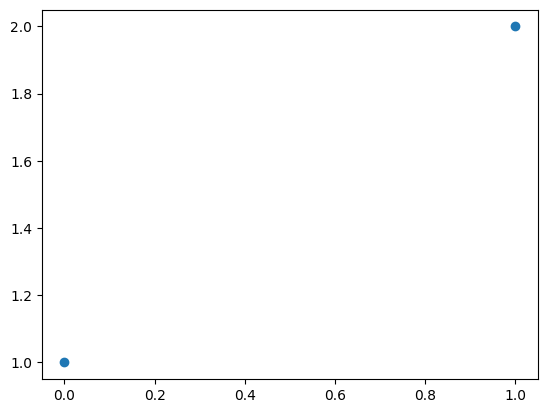

In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
import os
import flg_model
fls.profiling=False
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-3/', fls.result_dir + '/many_full_res/')

In [2]:
files = glob.glob(fls.result_dir + 'many_full_res/Baseline_2001_*')
assert len(files)==1
loaded_data = fls.dill_load(files[0])
test_data = loaded_data.test_data
print(loaded_data.modifier_values)


{'seed': 2001, 'n_ensemble': 1, 'n_epochs': 31, 'use_best_epoch': False, 'lr0': 0.0007852718891746083, 'cos_lr': True, 'mosaic': 1.0, 'concentration': 1, 'extra_data': True, 'trust_neg': 1, 'trust_extra': 1, 'model_name': 'yolov8s', 'use_pretrained_weights': False}


In [3]:
print([d.name for d in test_data[:30]])

['tomo_512f98', 'tomo_d0d9b6', 'tomo_53c71b', 'tomo_bcb115', 'tomo_1da0da', 'tomo_e1a034', 'tomo_b8595d', 'tomo_47d380', 'tomo_b4d9da', 'tomo_e764a7', 'tomo_04d42b', 'tomo_285454', 'tomo_f1bf2f', 'tomo_ac9fef', 'tomo_1fb6a7', 'tomo_b28579', 'tomo_91031e', 'tomo_b9de3e', 'tomo_35ec84', 'tomo_e9b7f2', 'tomo_bb5ac1', 'tomo_db6051', 'tomo_fe85f6', 'tomo_fd41c4', 'tomo_4f5a7b', 'tomo_499ee0', 'tomo_646049', 'tomo_e9fa5f', 'tomo_9ae65f', 'tomo_aeaf51']


In [ ]:
highest_false_score = []
real_score = []
data_list = []
for i_type in range(2):
    base_model = copy.deepcopy(loaded_data.trained_model)
    #base_model.step1Labels.n_ensemble=1
    #base_model.step1Labels.trained_model = base_model.step1Labels.trained_model[0:1]
    base_model.step1Labels.concentration = 2
    base_model.run_in_parallel=False
    model = base_model
    #model.step1Labels.n_epochs = 2
    #m.step2Motors.distance_threshold = 10.
    # if i_type == 0:
    #     # baseline
    #     pass     
    # elif i_type==1:
    #     # other seed
    #     model.step1Labels.trained_model = loaded_data.trained_model.step1Labels.trained_model[1:2]
    # elif i_type==2:
    #     model.step1Labels.preprocessor.voxel_scale = 0.9
    # elif i_type==3:
    #     model.step1Labels.preprocessor.voxel_scale = 0.8
    # elif i_type==4:
    #     model.step1Labels.preprocessor.blur_xy *= 0.8
    # elif i_type==5:
    #     model.step1Labels.preprocessor.blur_xy *= 1.2   
    # elif i_type==6:
    #     model.step1Labels.preprocessor.clip_value = 2.5
    # elif i_type==7:
    #     model.step1Labels.preprocessor.clip_value = 3.5
    # elif i_type==8:
    #     model.step1Labels.preprocessor.apply_transpose = True
    # elif i_type==9:
    #     model.step1Labels.preprocessor.apply_flipud = True
    if i_type == 0:
        # conc1
        model.step1Labels.concentration = 1     
    elif i_type==1:
        # conc2
        model.step1Labels.concentration = 2
    elif i_type==2:
        model.step1Labels.concentration = 1
        model.step1Labels.n_ensemble = 1
        model.step1Labels.trained_model = model.step1Labels.trained_model[0:1]
    elif i_type==3:
        model.step1Labels.concentration = 2
        model.step1Labels.n_ensemble = 1
        model.step1Labels.trained_model = model.step1Labels.trained_model[0:1]
    #model.step1Labels.relative_confidence_threshold = 0.01
    data_file = fls.temp_dir + 'data_tta_' + str(i_type) + '.pickle'    
    if not os.path.isfile(data_file):        
        inferred_data = model.infer(test_data)
        #for d in inferred_data:
        #    d.labels_unfiltered = d.labels_unfiltered2 
        fls.mark_tf_pn(inferred_data, test_data)
        fls.dill_save(data_file, inferred_data)        
    inferred_data = fls.dill_load(data_file)       
    data_list.append(inferred_data)
    this_highest_false_score = []
    this_real_score = []
    for i,r in zip(inferred_data, test_data):
        false_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==1.]
        if len(false_positives)>0:
            this_highest_false_score.append(np.max(false_positives['confidence']))
        else:
            this_highest_false_score.append(0)
        if len(r.labels)>0:
            true_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==0.]
            #print(true_positives)
            if len(true_positives)>0:
                this_real_score.append(np.max(true_positives['confidence']))
            else:
                this_real_score.append(0)
    highest_false_score.append(this_highest_false_score)
    real_score.append(this_real_score)

C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Clearing cupy
YOLOv8s summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
Processing tomogram tomo_512f98 (1/1)
Processing 800 out of 800 slices (CONCENTRATION=1)
------------------
   index    z    y    x  confidence  i_model
0      0  458  431  648    0.211426        0
------------------
------------------
    index   z    y    x  confidence  i_model
0       1  63  121  524    0.196167        0
1       2  67  124  529    0.194336        0
2       3  62  120  523    0.184814        0
3       4  65  124  527    0.181274        0
4       6  64  124  524    0.172729        0
..    ...  ..  ...  ...         ...      ...
63    129  63  119  531    0.046906        0
64    135  75  119  530    0.045868        0
65    137  64  115  527    0.045532        0
66    143  55  125  521    0.044006        0
67    145  65  114  528    0.043518        0

[68 rows x 6 columns]
------------------
------------------
   index    z    y    x  confidence  i_model
0      5  119  376  

In [ ]:
for d in data_list:
    n_corr=0
    n_total=0
    for i,r in zip(d,test_data):
        if len(r.labels)>0:# and 'tom' in r.name:
            n_total+=1
            ind = np.argmax(i.labels_unfiltered['confidence'])
            if (i.labels_unfiltered['tf_pn'].tolist()[ind])==0.:
                n_corr += 1
    print(n_corr/n_total)
    #print(i.labels_unfiltered)

In [ ]:
i_baseline = 1
for i_new in np.arange(1,len(highest_false_score)):
    _,ax=plt.subplots(1,2,figsize=(10,5))
    plt.sca(ax[0])
    plt.scatter(highest_false_score[i_baseline], highest_false_score[i_new])
    plt.xlabel('Highest false score baseline')
    plt.ylabel('Highest false score new')
    plt.grid(True)
    plt.axline((0,0),slope=1)
    plt.sca(ax[1])
    plt.scatter(real_score[i_baseline], real_score[i_new])
    plt.xlabel('True score baseline')
    plt.ylabel('True score new')
    plt.grid(True)
    plt.axline((0,0),slope=1)
    plt.suptitle(str(i_new))

In [ ]:
xx=(np.argwhere(np.logical_and(np.array(real_score[0])>0.6, np.array(real_score[2])<0.05))).flatten()
xx

In [ ]:
cur_id = 0
for ii in range(len(test_data)):
    if len(test_data[ii].labels)>0:     
        if cur_id in xx:
            print(test_data[ii].name,ii,real_score[i_baseline][cur_id],real_score[i_new][cur_id])
        cur_id+=1

In [ ]:
# highest_false_score.append( (np.array(highest_false_score[0])+np.array(highest_false_score[-1])) /2)
# real_score.append( (np.array(real_score[0])+np.array(real_score[-1])) /2)
#highest_false_score.append( [min(a,b) for a,b in zip(highest_false_score[0],highest_false_score[-1])])
#real_score.append( [min(a,b) for a,b in zip(real_score[0],real_score[-1])])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

i_baseline = 0
for i_new in np.arange(1,len(highest_false_score)):
    # flatten the two arrays into one to get global bin edges
    all_scores = np.concatenate([highest_false_score[i_baseline], highest_false_score[i_new]])
    # choose number of bins (e.g. 30) or compute automatically
    bins = np.histogram_bin_edges(all_scores, bins=30)
    
    _,ax=plt.subplots(1,2,figsize=(10, 5))
    plt.sca(ax[0])
    plt.hist(highest_false_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
    plt.hist(highest_false_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('False (we want to see orange)')
    plt.legend()
    plt.tight_layout()
    
    # flatten the two arrays into one to get global bin edges
    all_scores = np.concatenate([real_score[i_baseline], real_score[i_new]])
    # choose number of bins (e.g. 30) or compute automatically
    bins = np.histogram_bin_edges(all_scores, bins=30)

    plt.sca(ax[1])
    plt.hist(real_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
    plt.hist(real_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('True (we want to see blue)')
    plt.legend()
    plt.tight_layout()

    plt.suptitle(str(i_new))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
def visualize_fp_fn(data, threshold_fp, threshold_fn):

    all_data = fls.load_all_train_data() + fls.load_all_extra_data()
    def visualize_slice(name, z,y,x, color, title_str):
        for d in all_data:
            if d.name == name:
                break
        else:
            raise 'Not found'
        d = copy.deepcopy(d)
        prep = flg_preprocess.Preprocessor2()
        prep.load_and_preprocess(d, desired_original_slices = [z])

        plt.figure()
        plt.imshow(d.data[0,:,:], cmap='bone')
        plt.colorbar()
        plt.title(title_str + ': ' + name + ', ' + str(z))

        plt.scatter([x*d.resize_factor], [y*d.resize_factor], alpha=0.3, color=color, s=200)
    
    for d in data:  
        if not 'tom' in d.name:
            continue
        lab = copy.deepcopy(d.labels_unfiltered).reset_index()

        # false negatives
        if not np.any(np.logical_and(lab['tf_pn']==0., lab['confidence']>threshold_fn)):
            for r in all_data:
                if r.name == d.name:
                    break
            else:
                raise 'Not found'
            if len(r.labels)>0:
                attempts = lab[lab['tf_pn']==0.]
                if len(attempts)>0:
                    thresh = np.max(attempts['confidence'])
                else:
                    thresh = 0.
                visualize_slice(d.name, np.round(r.labels['z'][0]).astype(int),r.labels['y'][0],r.labels['x'][0], 'blue', 'False negative: '+str(thresh))

        # false positives
        slices_done = []
        for i_row in range(len(lab)):
            if lab['tf_pn'][i_row]==1. and lab['confidence'][i_row]>threshold_fp and lab['z'][i_row] not in slices_done:
                #print('fp', d.name, lab['z'][i_row], lab['confidence'][i_row])
                visualize_slice(d.name, lab['z'][i_row],lab['y'][i_row],lab['x'][i_row], 'red', 'False positive ' + str(lab['confidence'][i_row]))
                for ii in np.arange(lab['z'][i_row]-10, lab['z'][i_row]+11):
                    slices_done.append(ii)
#visualize_fp_fn(data_list[i_new], 0.8, 0.8)

In [ ]:
for transpose in [False,True]:
    prep = model.step1Labels.preprocessor
    prep.apply_flipud = transpose
    dat = copy.deepcopy(test_data[0])
    prep.load_and_preprocess(dat)
    plt.figure()
    plt.imshow(dat.data[dat.data.shape[0]//2,...], cmap='bone')


In [ ]:
dat.data_shape

In [ ]:
def visualize_slice(data, z_list):
    # preprocessor = copy.deepcopy(models[0].trained_model.step1Labels.preprocessor)
    # #preprocessor.blur_z = 5
    # preprocessor.blur_xy = 1
    # preprocessor.scale_moving_average = True
    # preprocessor.scale_also_moving_std = True
    # #preprocessor.moving_ratio = 0.
    # data = copy.deepcopy(data)
    # preprocessor.load_and_preprocess(data, desired_original_slices = z_list)
    # dat = []
    # for mm in range(1):
    #     m = copy.deepcopy(models[mm].trained_model)
    #     m.step1Labels.preprocessor = preprocessor
    #     m.step1Labels.relative_confidence_threshold = 0.001
    #     m.step2Motors.distance_threshold = 10.
    #     m.run_in_parallel = False
    #     dat.append (m.infer([data])[0])
    m = copy.deepcopy(base_model)
    m.step1Labels.concentration = 1
    #m.step1Labels.preprocessor.blur_z = 60
    #m.step1Labels.img_size //= 4
    m.step1Labels.relative_confidence_threshold = 0.01
    #m.step1Labels.preprocessor.apply_transpose = True
    #m.step1Labels.concentration = 2
    #m.step1Labels.prevent_ultralytics_resize = True
    m.run_in_parallel = False
    dat = []
    dat.append (m.infer([data])[0])
    data = copy.deepcopy(data)
    m.preprocessor.load_and_preprocess(data, desired_original_slices = z_list)
    #m.step1Labels.n_ensemble = 1
    #m.step1Labels.trained_model = m.step1Labels.trained_model[0:1]
    for i_z,z in enumerate(data.slices_present):
    #     if data.slices_present[i_z]==z:
    #         break
    # else:
    #     raise 'stop'
        plt.figure()
        plt.imshow(data.data[i_z,:,:], cmap='bone')
        plt.colorbar()
        plt.title(data.name + ', ' + str(z))
        for d in dat:
            print(d.labels)
            print(d.labels_unfiltered)
            print(d.labels_unfiltered2)
            assert d.name == data.name
            to_plot = d.labels_unfiltered2
        
            to_plot = to_plot[to_plot['z']==z]
            print('z: ', z)
            print(to_plot)
    
            plt.scatter(data.resize_factor*to_plot['x'], data.resize_factor*to_plot['y'])
#             #print(dat)    
    # for mm in range(1):
    #     # m = copy.deepcopy(models[mm].trained_model)
    #     # m.step1Labels.relative_confidence_threshold = 0.01
    #     # m.step2Motors.distance_threshold = 10.
    #     # m.run_in_parallel = False
    #     # dat = m.infer([data])
    #     dat = models[mm].inferred_test_data
    #     for d in dat:
    #         if d.name == data.name:
    #             to_plot = d.labels_unfiltered2
            
    #             to_plot = to_plot[to_plot['z']==z]
    #             print(to_plot)
        
    #             plt.scatter(to_plot['x'], to_plot['y'])
    #             #print(dat)    

In [ ]:
import flg_yolo2
importlib.reload(flg_yolo2)
for ind in [89]:
    dat= data_list[0][ind]
    print(dat.labels)
    #if len(dat.labels)>0:
    #    visualize_slice(dat, [dat.labels['z'][0]])
    visualize_slice(dat, [539])

In [ ]:
dat